In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.fftpack import * 

数据读取、处理边界、DCTN计算部分

In [2]:
ke_sum = {}
dir_out = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['rcm'] = ds_ke_sum['vertical integration Ke']

dir_out = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi/"
ds_ke_sum = xr.open_dataset(dir_out + "ke_all_400-100_hPa_vi.nc")
ke_sum['vr'] = ds_ke_sum['vertical integration Ke']

In [3]:
# 通过外插，去除掉边界上因RCM范围选取问题产生的nan的点
ke_sum_rmnan = {}
ke_sum_rmnan['vr'] = ke_sum['vr'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")
ke_sum_rmnan['rcm'] = ke_sum['rcm'].interpolate_na(dim = 'longitude', method = 'cubic', max_gap = None, fill_value="extrapolate")

In [4]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
res_dctn = {}
res_dctn['vr'] = dctn(ke_sum_rmnan['vr'].values, type = 2, axes = [1,2])
res_dctn['rcm'] = dctn(ke_sum_rmnan['rcm'].values, type = 2, axes = [1,2])

In [5]:
# 添加维度参数
ntime = res_dctn['vr'].shape[0]
nlat  = res_dctn['vr'].shape[1]
nlon  = res_dctn['vr'].shape[2]
# 添加频谱参数


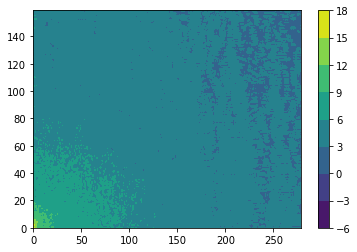

In [9]:
# plt.contourf(np.log(np.abs(res_dctn['vr'][nlat//2:,nlon//2:].mean(axis=0))))
# plt.contourf(np.log(np.abs(res_dctn['vr'][nlat//2:,nlon//2:].mean(axis=0))))
plt.contourf(np.log(np.abs(res_dctn['vr'][:,:].mean(axis=0))))
plt.colorbar()

In [10]:
# 移动零频率到中心
dctn_shift  = {}
dctn_timean = {}
# dctn_timean['vr'] = res_dctn['vr'].mean(axis=0)
dctn_shift['vr']  = fftshift(res_dctn['vr'].mean(axis=0), axes=[0,1])

# dctn_timean['rcm'] = res_dctn['rcm'].mean(axis=0)
dctn_shift['rcm']  = fftshift(res_dctn['rcm'].mean(axis=0), axes=[0,1])
 
# plt.contourf(np.log(np.abs(dctn_shift[nlat//2:,nlon//2:])))
# plt.colorbar()

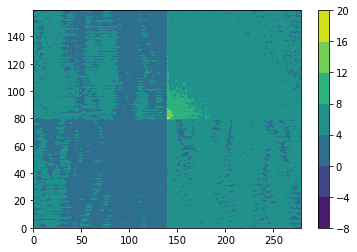

In [11]:
# plt.contourf(np.log(np.abs(dctn_shift['rcm'][nlat//2:,nlon//2:])))
plt.contourf(np.log(np.abs(dctn_shift['rcm'][:,:])))
plt.colorbar()

使用 turbustat 进行1D功率谱的预估

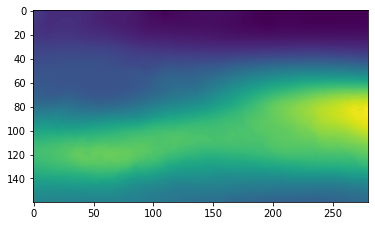

In [8]:
from turbustat.statistics import PowerSpectrum
from astropy.io import fits
rnoise_img = ke_sum_rmnan['vr'].values.mean(axis=0)
plt.imshow(rnoise_img)  

/m2data2/yycheng/anaconda3/envs/pync0326/lib/python3.9/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     613.1
Date:                Mon, 28 Jun 2021   Prob (F-statistic):           1.32e-56
Time:                        19:39:04   Log-Likelihood:                -138.24
No. Observations:                 162   AIC:                             280.5
Df Residuals:                     160   BIC:                             286.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
         

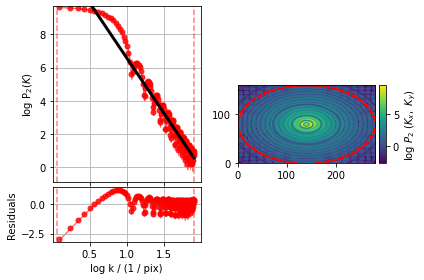

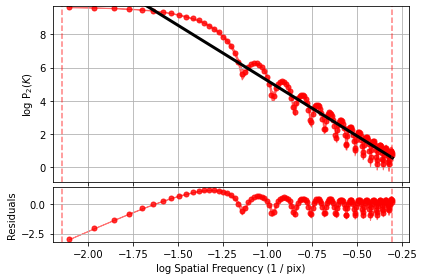

In [10]:
rnoise_hdu = fits.PrimaryHDU(rnoise_img)

from turbustat.statistics import PowerSpectrum
pspec = PowerSpectrum(rnoise_hdu)
pspec.run(verbose=True, radial_pspec_kwargs={'binsize': 1.0}, apodize_kernel = 'cosinebell', use_wavenumber=True)
# pspec.compute_radial_pspec(logspacing=True)
# pspec.run(verbose=True, radial_pspec_kwargs={'binsize': 1.0},
        #   fit_kwargs={'weighted_fit': True}, fit_2D=True)
pspec.plot_fit()

从二维谱 通过半径的 profile 预估一维谱 工地

In [197]:
#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    from  scipy  import ndimage 
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D
#===================================================================

In [241]:
    psd2D = dctn_shift['rcm']
    from  scipy  import ndimage 
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    # psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))
    psd1D = ndimage.sum(psd2D, r, index=np.unique(r))

<ipython-input-241-a9a567cc5a9c>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r    = np.hypot(X - wc, Y - hc).astype(np.int)


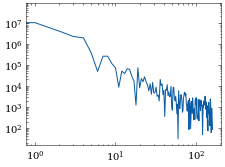

In [233]:
psd1D
# np.unique(r)
plt.plot(np.unique(r),np.abs(psd1D))
plt.yscale('log')
plt.xscale('log')

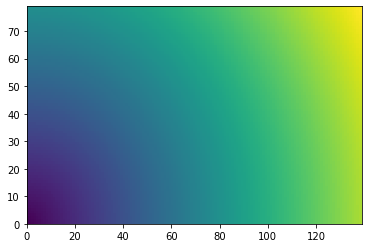

In [12]:
# # # dctn_shift.shape 160 x 280
# # # 2d wavenumber k_2d
# # 经向间距 5017km（dy） 纬向间距 7061km（dx）
# dx = 7061. / nlon
# dy = 5017. / nlat
# wavelen_2d = np.empty(shape = [nlat//2,nlon//2])
freq_2d = np.empty(shape = [nlat//2,nlon//2])
for i in range(0, nlon//2):
    for j in range(0, nlat//2):
        # x_loc = 7061. / i
#         y_loc = 5017. / j
        # wavelen_2d[j,i] = np.sqrt(x_loc**2 + y_loc**2)
        freq_2d[j,i] = np.sqrt(i**2 + j**2)
# for i in range(1,nlon//2):                       
#     wavelen_2d[i,0] = i * (dx)
# # freq_2d_ravel = freq_2d.ravel()
# # dctn_shift_ravel = dctn_shift[nlat//2:, nlon//2: ].ravel()
# # 大致的波长的分布情况
plt.pcolormesh(freq_2d[1:,1:])

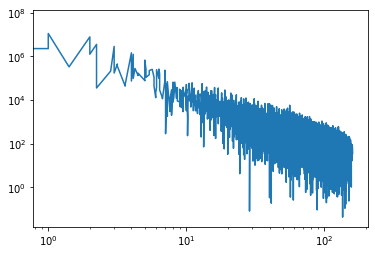

In [171]:
freq_sort = np.argsort(freq_2d.ravel(),axis = 0) # 从小到大排序
freq_1d   = freq_2d.ravel()[freq_sort]
dctn_vr_1d  = dctn_shift['vr'][nlat//2:,nlon//2:].ravel()[freq_sort]
plt.plot(freq_1d, np.abs(dctn_vr_1d))
plt.yscale('log')
plt.xscale('log')

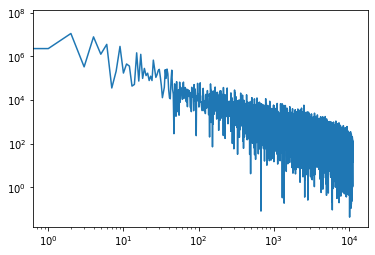

In [170]:
plt.plot(np.abs(dctn_vr_1d))
plt.yscale('log')
plt.xscale('log')

In [32]:
dctn_shift['vr'][nlat//2:, nlon//2: ].shape # 81 x 141


AttributeError: 'dict' object has no attribute 'shape'

In [103]:
# 计算谱对应的频率等基本参数
dct_var = vr_ke_dct_mean.size
# Number of samplepoints
N = vr_ke_dct_mean.size
# sample spacing
T = 1 / N
# xf freq
xf = fftfreq(N, T)[:N//2]
domain_lon_range = 7061. # km
xf_length = domain_lon_range / xf

# 计算测地线


<ipython-input-103-1a923f4c7014>:10: RuntimeWarning: divide by zero encountered in true_divide
  xf_length = domain_lon_range / xf


In [187]:
freq_2d_ravel.shape
dctn_shift_ravel.shape

(11200,)

<ipython-input-242-d53c4e574fde>:9: RuntimeWarning: divide by zero encountered in power
  yref_synop = xf ** (-3.) * 1e3
<ipython-input-242-d53c4e574fde>:10: RuntimeWarning: divide by zero encountered in power
  yref_meso  = xf ** (-5./3) * 1e2


Text(0.5, 0.98, '400-100hPa total Ke 1D-DCT spectra')

<ipython-input-242-d53c4e574fde>:30: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / x )/ domain_lon_range


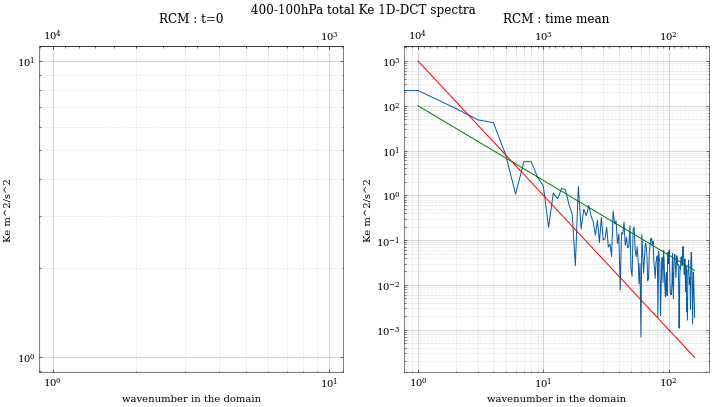

In [242]:
fig, axs = plt.subplots(1,2,figsize=(12, 6))
plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

xf = np.unique(r)
# plt.plot(freq_1d, np.abs(dctn_vr_1d))
# axs[1].plot(freq_1d, 1.0/nlon/nlat * np.abs(dctn_vr_1d))
axs[1].plot(xf, 1.0/nlon/nlat * np.abs(psd1D))
# add reference line 
yref_synop = xf ** (-3.) * 1e3
yref_meso  = xf ** (-5./3) * 1e2
axs[1].plot(xf, yref_synop,color='r')
axs[1].plot(xf, yref_meso,color='g')

# axs[1].plot(freq_2d_ravel, np.abs(dctn_shift_ravel))
# add reference line
# yref_synop = xf ** (-3.) * 1e1
# yref_meso  = xf ** (-5./3) * 1e1
# axs[1].plot(xf, yref_synop,color='r')
# axs[1].plot(xf, yref_meso,color='g')
# plt.plot(xf[1:], 2.0/N * np.abs(yf[0:int(N/2)])[1:])



def upper_xaxis(x):
    domain_lon_range = 7061. * np.sqrt(2) # km
    return domain_lon_range / x

def upper_xaxis_inv(x):
    domain_lon_range = 7061. * np.sqrt(2) # km
    return (1. / x )/ domain_lon_range 

for axs_ind in axs:
    axs_ind.set_yscale('log')
    axs_ind.set_xscale('log')
    axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) )

    axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.xaxis.grid(True, which="major", linestyle = "-")
    axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
    axs_ind.yaxis.grid(True, which="major", linestyle = "-")

    axs_ind.set_xlabel('wavenumber in the domain')
    axs_ind.set_ylabel('Ke m^2/s^2')
axs[0].set_title('RCM : t=0')
axs[1].set_title('RCM : time mean')
# axs[0].legend()
fig.suptitle("400-100hPa total Ke 1D-DCT spectra")
